In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Utility import
from rfa_utils import general_fns as gf
from rfa_utils import clean_crypto as cc
# Analysis import
from rfa_ana import analysis as ana

In [2]:
crypto_path = os.path.join('data/crypto/', 'imputed-data.xlsx')
# Import crypto dataframes except XMR
crypto = gf.import_excel(
    crypto_path,
    ['btc', 'xrp', 'doge', 'ltc', 'bch', 'xlm', 'bsv', 'zec', 'dash']
)
# Convert to pandas
for df in crypto:
    crypto[df] = crypto[df].to_pandas()
    crypto[df].index = crypto[df]['date']
    crypto[df] = crypto[df].drop(columns=['date'])

In [3]:
def crypto_fee_percentage(dfs: dict) -> dict:
    """Calculate and create a new column for fee percentage based on average transaction fees and values"""
    for _, df in dfs.items():
        df['fee_percentage'] = (df['average_transaction_fees'] / df['average_transaction_value']) * 100
    return dfs

In [4]:
# Add fee percentage column to crypto dict
crypto = ana.crypto_fee_percentage(crypto)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid") 

def crypto_fee_percentage_lineplot(dfs: dict) -> None:
    """Plot the fee percentage column for all dataframes in the dictionary on a weekly basis"""
    plt.figure(figsize=(10, 6))
    for name, df in dfs.items():
        # Resample to weekly frequency 
        df_weekly = df.resample('W').median()  
        # Calculate rolling mean with 4 week window
        df_roll = df_weekly.rolling(4, min_periods=1).mean()
        # Plot smoothed line
        sns.lineplot(data=df_roll, x=df_roll.index, y='fee_percentage', label=name)
    plt.xlabel('date')
    plt.ylabel('Fee Percentage')
    plt.title('Fee Percentage Plot (Weekly)')
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

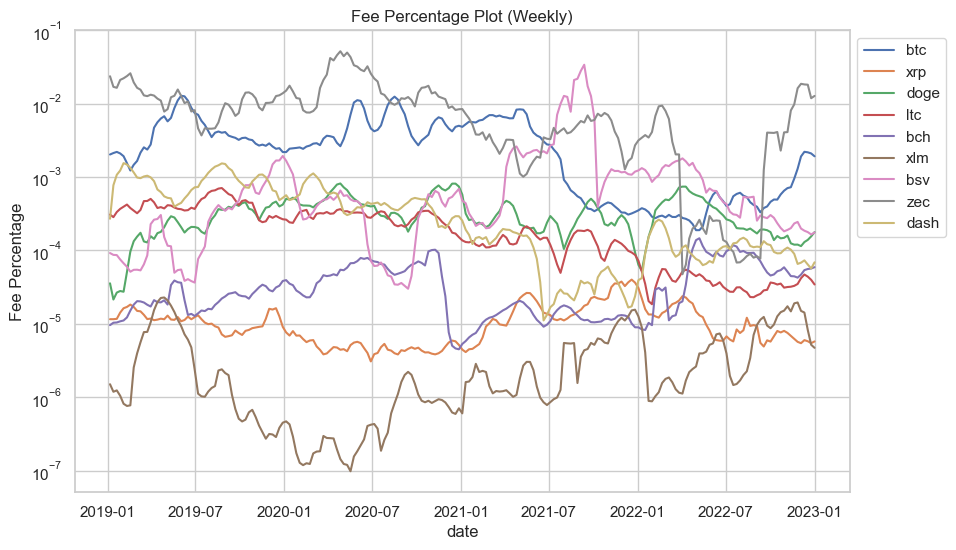

In [6]:
# Create lineplots for fee percentages
ana.crypto_fee_percentage_lineplot(crypto)

In [7]:
import pandas as pd

def crypto_fees_scenarios(dfs: dict) -> pd.DataFrame:
    """Create a dataframe that has different scenarios for each year for crypto fee percentage"""
    scenario_data = []
    for name, df in dfs.items():
        for year in range(2019, 2023):
            df_year = df[df.index.year == year]
            # Get the mean value of fee_percentage directly
            fee_percent = df_year['fee_percentage'].describe().loc['mean']
            # Get the mean value of 24h_volume directly
            volume_weight = df_year['24h_volume'].mean()
            scenario_data.append({
                'crypto': name,
                'year': year,
                'mean_fee_percent': fee_percent,
                'volume_weight': volume_weight
            })
    # Create dataframe and reorder columns
    scenario_df = pd.DataFrame(scenario_data)
    scenario_df = scenario_df.reindex(columns=['crypto', 'year', 'mean_fee_percent', 'volume_weight'])
    return scenario_df

def combine_average_case(scenario_df: pd.DataFrame) -> pd.DataFrame:
    """Create a dataframe that has the weighted_average_case for each year using the volume_weight"""
    combined_data = []
    for year in range(2019, 2023):
        scenario_df_year = scenario_df[scenario_df['year'] == year]
        # Calculate the weighted_average_case using the formula
        weighted_mean_fee = (scenario_df_year['mean_fee_percent'] * scenario_df_year['volume_weight']).sum() / scenario_df_year['volume_weight'].sum()
        combined_data.append({
            'year': year, 
            'Crypto': weighted_mean_fee * 100
        })
    # Create dataframe
    combined_df = pd.DataFrame(combined_data)
    combined_df.index = combined_df['year']
    combined_df = combined_df.drop(columns=['year'])
    return combined_df

In [8]:
crypto_scenarios = ana.crypto_fees_scenarios(crypto)
crypto_fees = ana.combine_average_case(crypto_scenarios)

In [9]:
stablecoin_path = os.path.join('data/stablecoin/', 'imputed-data.xlsx')
# Import stablecoin dataframes
stablecoin = gf.import_excel(
    stablecoin_path,
    ['usdt', 'usdc', 'busd', 'dai', 'tusd', 'usdp', 'gusd', 'fees']
)
# Convert to pandas
for df in stablecoin:
    stablecoin[df] = stablecoin[df].to_pandas()
    stablecoin[df].index = stablecoin[df]['date']
    stablecoin[df] = stablecoin[df].drop(columns=['date'])

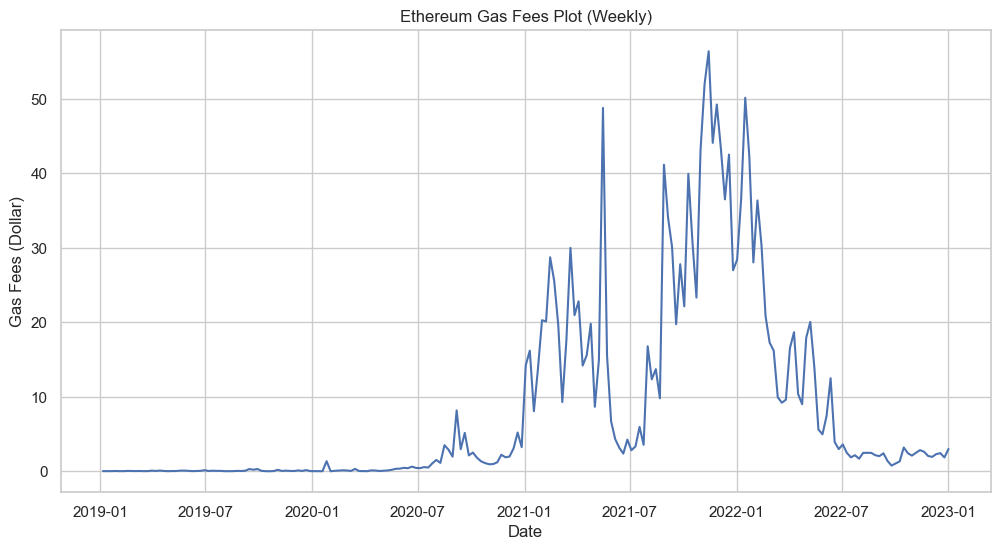

In [10]:
# Plot weekly gas fees
ana.plot_gas_fees(stablecoin['fees'])

In [11]:
stablecoin_fees = ana.stablecoin_fees_scenarios(stablecoin['fees'])

In [12]:
remittance_path = os.path.join('data/remittance/', 'remittance-tables.xlsx')
# Import remittance dataframes
remittance = gf.import_excel(
    remittance_path,
    ['cost_to_income', 'cost_to_region', 'cost_from_income', 'cost_from_region',
     'inflow_income', 'inflow_region', 'outflow_income', 'outflow_region']
)
# Convert to pandas
for name in remittance:
    # Convert to pandas
    remittance[name] = remittance[name].to_pandas()
    # Impute missing columns in cost_from dataframes
    if name == 'cost_from_income' or name == 'cost_from_region':
        remittance[name] = cc.mf_impute(remittance[name])
    remittance[name].index = remittance[name]['year']
    remittance[name] = remittance[name].drop(columns=['year'])

In [13]:
# Generate predictions for 2021/2022 for income to/from tables
pred_dict = {}
for key in remittance.keys():
    # Check if the dataframe has 2021 and 2022 or not
    if 2021 not in remittance[key].index and 2022 not in remittance[key].index:
        # Call the function on each dataframe
        pred_df = ana.predict_remittance_cost(remittance[key])
        # Store the predictions in the new dict
        pred_dict[key] = pred_df
        # Append the predictions to the original dataframes
        remittance[key] = pd.concat([remittance[key], pred_df], axis=0)

In [14]:
# Remittance dataframes
cti = remittance['cost_to_income']
ctr = remittance['cost_to_region']

# Create concatenated dataframe for 2019-2022 along columns with keys
all_fees = pd.concat([
    crypto_fees,
    stablecoin_fees,
    cti[(cti.index >= 2019) & (cti.index <= 2022)],
    ctr[(ctr.index >= 2019) & (ctr.index <= 2022)]
], axis=1)

In [15]:
all_fees

,Crypto,Stablecoin,High income,Low income,Lower middle income,Upper middle income,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,South Asia,Sub-Saharan Africa
year,,,,,,,,,,,,
2019,0.337492,0.042753,4.717689,8.943462,7.773704,6.994793,8.875822,5.230279,5.864763,6.867482,5.542305,9.988641
2020,0.426712,0.761924,5.162275,9.724071,7.439337,6.998120,8.486824,5.232073,5.993455,9.424071,5.484916,9.636779
2021,0.237932,11.167482,4.396091,8.255217,7.457025,6.930147,9.126888,4.993645,5.574648,7.648419,5.499500,9.035775
2022,0.062314,4.979218,4.103572,7.914166,7.326742,6.868673,9.077378,4.911251,5.454280,7.661870,5.477824,8.655457


In [16]:
# Reshape the dataframe from wide to long
all_fees = all_fees.reset_index()
long_fees = pd.melt(all_fees, id_vars='year', var_name='group', value_name='fee_percentage')

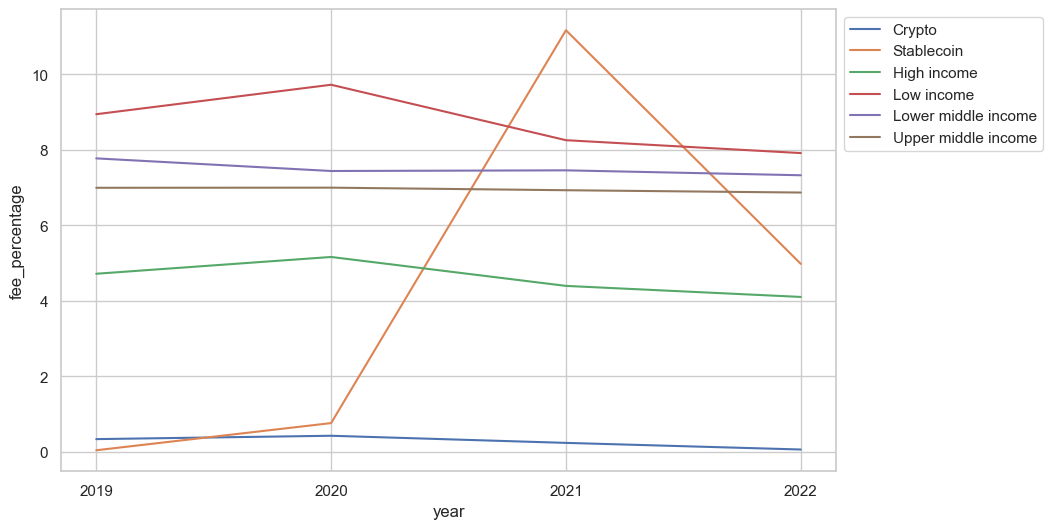

In [17]:
# Select the columns for Crypto, Stablecoin, and Income groups
df = all_fees.loc[:, ['year', 'Crypto', 'Stablecoin', 'High income', 'Low income', 'Lower middle income', 'Upper middle income']]

# Reshape the dataframe from wide to long
long_fees = pd.melt(df, id_vars='year', var_name='group', value_name='fee_percentage')

# Plot each group over the four years
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=long_fees, x='year', y='fee_percentage', hue='group', errorbar=None)
plt.xticks([2019, 2020, 2021, 2022])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

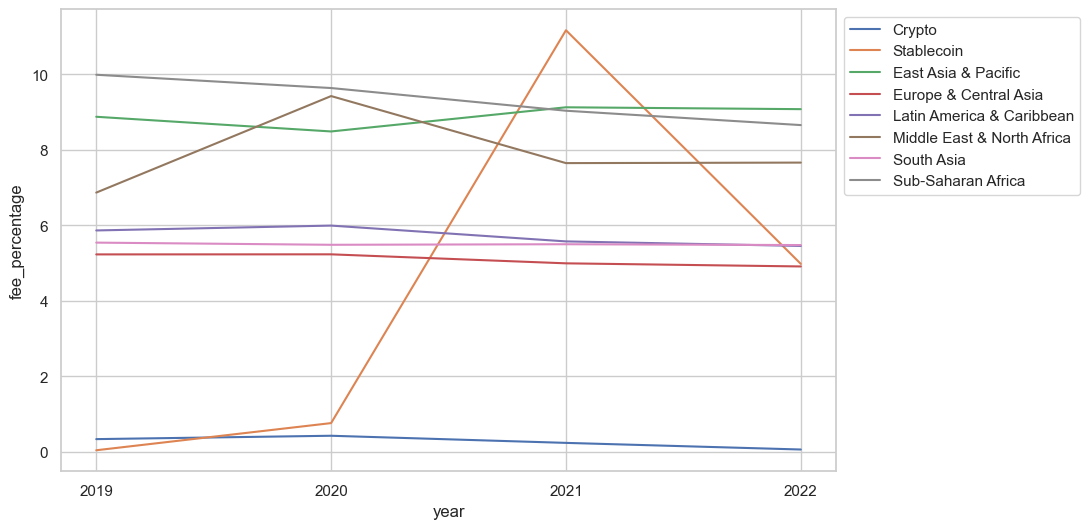

In [18]:
# Select the columns for Crypto, Stablecoin, and Region groups
df = all_fees.loc[:, ['year', 'Crypto', 'Stablecoin', 'East Asia & Pacific', 'Europe & Central Asia', 'Latin America & Caribbean', 'Middle East & North Africa', 'South Asia', 'Sub-Saharan Africa']]

# Reshape the dataframe from wide to long
long_fees = pd.melt(df, id_vars='year', var_name='group', value_name='fee_percentage')

# Plot each group over the four years
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=long_fees, x='year', y='fee_percentage', hue='group', errorbar=None)
plt.xticks([2019, 2020, 2021, 2022])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()